In [1]:
import numpy as np
from numpy import linalg as LA
import scipy
import scipy.io as sio
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
from pylab import *
from collections import namedtuple
from os.path import dirname, join as pjoin
import sofa
import inspect

import sys
sys.path.append(r'C:\Users\root\Documents\00phd\00Code\ForSignalProcessing\spaudiopy\spaudiopy') 
# import spaudiopy

In [2]:
class HRTFdataclass:
    def __init__(self):
        self.fs=[]
        self.HRIR_L=[]
        self.HRIR_R=[]
        self.HRTF_L=[]
        self.HRTF_R=[]
        self.sid=[]
        self.ITD=[]
        self.DTF_L=[]
        self.DTF_R=[]
        self.DTF2_L=[]
        self.DTF2_R=[]
        self.meanHRTF_L=[]
        self.meanHRTF_R=[]
class HRTFPCA:
    def __init__(self):
        self.weights_L=[]
        self.weights_R=[]
        self.nBases=[]
        self.DTF2synth_L=[]
        self.DTF2synth_R=[]
        self.HRTF2_L=[]
        self.HRTF2_R=[]
        self.MSE_L=[]
        self.MSE_R=[]
        self.L2_L=[]
        self.L2_R=[]

In [3]:
HRTFdata=HRTFdataclass()
HRTFdata_full=[]

# Define parameters
fs = 44100
Nbases = [1,5,10,20,30,50,75,100,129]   # number of bases to be selected from 
N = 256; # FFT length

# load data
names=os.listdir('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/')
# print(names)
# column_names=['id','elevation','azimuth','hrtf']
# input=pd.DataFrame(columns=column_names)
# input.id=names[1:]
# print(input)

for i in range(1, len(names)):  
    data_dir = pjoin('C:/Users/root/Documents/00phd/00ThirdPartyCode/ForSignalProcessing/SOFA API/SOFA API for Matlab and Octave 1.1.1/HRTFs/CIPIC_hrtf_database/standard_hrir_database/', names[i])
    mat_fname = pjoin(data_dir, 'hrir_final.mat')
    data=sio.loadmat(mat_fname)

    HRTFdata=HRTFdataclass()
    HRTFdata.fs=fs
    HRTFdata.sid=names[i] 
    HRTFdata.HRIR_L=data.get('hrir_l')
    HRTFdata.HRIR_R=data.get('hrir_r')
    HRTFdata.HRTF_L=scipy.fft.rfft(HRTFdata.HRIR_L,N,axis=-1)
    HRTFdata.HRTF_R=scipy.fft.rfft(HRTFdata.HRIR_R,N,axis=-1)
    HRTFdata.ITD=data.get('ITD')
    HRTFdata.DTF_L=np.zeros(HRTFdata.HRTF_L.shape,dtype = 'complex_')
    HRTFdata.DTF_R=np.zeros(HRTFdata.HRTF_L.shape,dtype = 'complex_')
    HRTFdata.DTF2_L=np.zeros(HRTFdata.HRTF_L.shape,dtype = 'complex_')
    HRTFdata.DTF2_R=np.zeros(HRTFdata.HRTF_L.shape,dtype = 'complex_')
    HRTFdata.meanHRTF_L=np.zeros(HRTFdata.HRTF_L.shape[2],dtype = 'complex_')
    HRTFdata.meanHRTF_R=np.zeros(HRTFdata.HRTF_L.shape[2],dtype = 'complex_')
    
    HRTFdata_full.append(HRTFdata) 


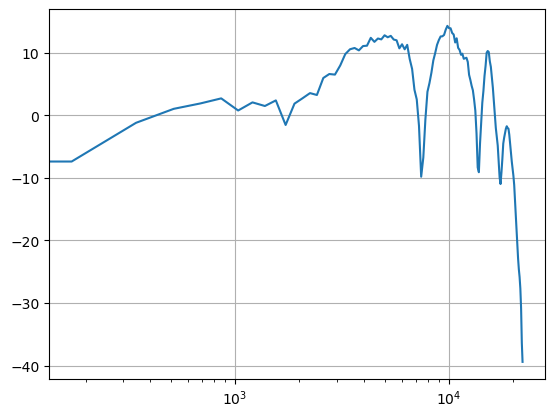

In [4]:
xx=scipy.fft.rfft(HRTFdata_full[0].HRIR_L[0,0,:],N,axis=-1)

freq=np.linspace(0, math.ceil(N/2), math.ceil(N/2)+1)*fs/N
#print(freq)
plt.semilogx(freq, 20*np.log10(np.abs(HRTFdata_full[0].HRTF_L[0,0,:])),label='HRTF_L')
plt.grid(True)

In [5]:
print(math.ceil(N/2)+1)

129


In [12]:
sum_DTF=np.zeros(HRTFdata_full[0].HRTF_L.shape[2],dtype = 'complex_')

# Compute DTF
for i in range(0, len(HRTFdata_full)): # for each subject
    Ptot_L = np.sum(np.power(HRTFdata_full[i].HRIR_L,2), axis=2) # total power in each HRIR, direction-dependent
    Ptot_R = np.sum(np.power(HRTFdata_full[i].HRIR_R,2), axis=2) 
    
    for j in range(0, HRTFdata_full[0].HRTF_L.shape[2]): # for each fft bin
        sum_L = np.sum(np.multiply(HRTFdata_full[i].HRTF_L.take(indices=j,axis=2),Ptot_L), axis=(0,1)) # weight the whole spectra by power at each direction (preserve the direction-dependent contribution)
        sum_R = np.sum(np.multiply(HRTFdata_full[i].HRTF_R.take(indices=j,axis=2),Ptot_R), axis=(0,1))
        # unweighted
        # sum_L = np.sum(HRTFdata_full[i].HRTF_L.take(indices=j,axis=2), axis=(0,1)) 
        # sum_R = np.sum(HRTFdata_full[i].HRTF_R.take(indices=j,axis=2), axis=(0,1))

        HRTFdata_full[i].meanHRTF_L[j] = sum_L / HRTFdata_full[0].HRTF_L[:,:,0].size     # mean HRTF across all directions for each subject
        HRTFdata_full[i].meanHRTF_R[j] = sum_R / HRTFdata_full[0].HRTF_L[:,:,0].size
        
        HRTFdata_full[i].DTF_L[:,:,j] = np.divide(HRTFdata_full[i].HRTF_L[:,:,j], HRTFdata_full[i].meanHRTF_L[j])    # subject-specific DTF
        HRTFdata_full[i].DTF_R[:,:,j] = np.divide(HRTFdata_full[i].HRTF_R[:,:,j], HRTFdata_full[i].meanHRTF_R[j])

    sum_DTF=sum_DTF+np.squeeze(np.sum(HRTFdata_full[i].DTF_L,axis=(0,1)))+np.squeeze(np.sum(HRTFdata_full[i].DTF_R,axis=(0,1))) #sum over subjects and directions 
    
grandMean=sum_DTF/(len(HRTFdata_full)*2*HRTFdata_full[0].HRTF_L[:,:,0].size) # mean of all DTFs across all subjects and directions and ears
#    subj.meanHRTF(i) = (subj.meanHRTF_l(i)+subj.meanHRTF_r(i)) / 2; # in case u need it

# Compute DTF2
for i in range(0, len(HRTFdata_full)): # for each subject
    HRTFdata_full[i].DTF2_L = np.divide(HRTFdata_full[i].DTF_L, np.reshape(grandMean,(1,1,len(grandMean))))    # element-wise division
    HRTFdata_full[i].DTF2_R = np.divide(HRTFdata_full[i].DTF_R, np.reshape(grandMean,(1,1,len(grandMean))))

In [13]:
mean_L=np.zeros(HRTFdata_full[0].HRTF_L.shape[2],dtype = 'complex_')
for i in range(0, len(HRTFdata_full)): # for each subject
    mean_L=mean_L+HRTFdata_full[i].meanHRTF_L

mean_L=mean_L/len(HRTFdata_full)

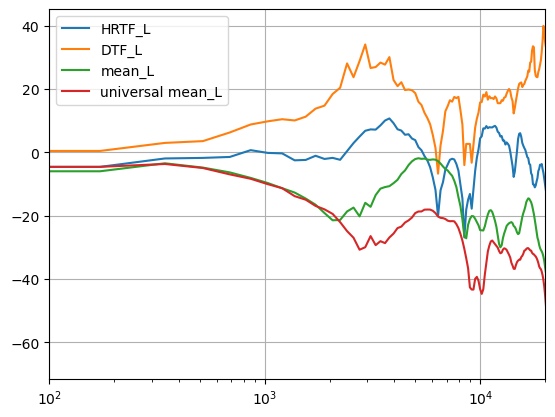

In [14]:
# Plot
plt.semilogx(freq, 20*np.log10(np.abs(HRTFdata_full[0].HRTF_L[11,4,:])),label='HRTF_L')
plt.semilogx(freq, 20*np.log10(np.abs(HRTFdata_full[0].DTF_L[11,4,:])),label='DTF_L')
plt.semilogx(freq,20*np.log10(np.abs(HRTFdata_full[10].meanHRTF_L)),label='mean_L')
plt.semilogx(freq,20*np.log10(np.abs(mean_L)),label='universal mean_L')
plt.grid(True)
plt.xlim(100,20000)
plt.legend()


In [10]:
# Calculate covariance matrices for each direction across all subjects
DTF2mag=np.zeros((2*len(HRTFdata_full),HRTFdata_full[0].DTF2_L.shape[2]))
COV=np.zeros((HRTFdata_full[0].DTF2_L.shape[2]))
COVsum=np.zeros((HRTFdata_full[0].DTF2_L.shape[2]))
for i in range(0, HRTFdata_full[0].DTF2_L.shape[0]): 
    for j in range(0, HRTFdata_full[0].DTF2_L.shape[1]): 
        for k in range(0, len(HRTFdata_full)):
            DTF2mag[k,:]=20*np.log10(np.squeeze(np.abs(HRTFdata_full[k].DTF2_L[i,j,:])))   # left ear
            DTF2mag[k+len(HRTFdata_full),:]=20*np.log10(np.squeeze(np.abs(HRTFdata_full[k].DTF2_R[i,j,:])))   # right ear
        COV=np.cov(DTF2mag.transpose()) # covariance matrix for each direction
        COVsum=COVsum+COV  # sum over all directions
COVavg=COVsum/(HRTFdata_full[0].DTF2_L.shape[0]*HRTFdata_full[0].DTF2_L.shape[1])
eigen_val, eigen_vec = LA.eig(COVavg)


In [26]:
# calculate cumulative variance
var=np.zeros(eigen_vec.shape[1])
for b in range(0,eigen_vec.shape[1]):
    var[b]=np.sum(eigen_val[0:b+1])/np.sum(eigen_val)
print(var[0:15])

[0.58400382 0.63838354 0.68429358 0.72613713 0.76284186 0.79204871
 0.81606867 0.83760043 0.8581936  0.87654041 0.8893584  0.90089352
 0.91152921 0.92083397 0.92889433]


In [ ]:
print(eigen_vec.shape)
plt.stem(eigen_val)
#print(eigen_val)

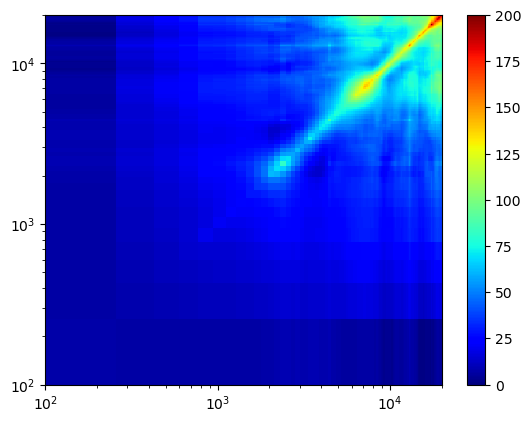

In [12]:
# Plot the mean covariance
fig, ax = plt.subplots()
X,Y = np.meshgrid(freq,freq)
surf = ax.pcolor(X,Y,COVavg, cmap=cm.jet, vmin=0, vmax=200)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(100,20000)
ax.set_ylim(100,20000)

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Show the plot
plt.show()

In [ ]:
# Find strongest eigenvalues and decompose
PCA_full=[]  # PCA_full is a list of instances HRTFPCA

for i in range(0,len(HRTFdata_full)):
    PCAdata=HRTFPCA()
    PCAdata.DTF2synth_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.DTF2synth_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.weights_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.weights_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.HRTF2_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.HRTF2_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape),len(Nbases)))
    PCAdata.MSE_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape[0:2]),len(Nbases)))
    PCAdata.MSE_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_L = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape[0:2]),len(Nbases)))
    PCAdata.L2_R = np.zeros(np.append(np.asarray(HRTFdata_full[0].DTF2_L.shape[0:2]),len(Nbases)))
    # PCAdata.nBases = Nbases
    for j in range(0,len(Nbases)):     
        PCAdata.nBases = Nbases[j]  
        eigen_vecProj = eigen_vec[:, 0:Nbases[j]]
        eigen_valProj = eigen_val[0:Nbases[j]] # build reduced covar matrix
        # print(PCAdata.nBases)
        for k in range(0, HRTFdata_full[0].DTF2_L.shape[0]):
            for l in range(0, HRTFdata_full[0].DTF2_L.shape[1]):
                weights_l = np.matmul(np.conjugate(eigen_vecProj.transpose()),20*np.log10(np.abs(np.squeeze(HRTFdata_full[i].DTF2_L[k,l,:]))))  # matrix multiplication
                weights_r = np.matmul(np.conjugate(eigen_vecProj.transpose()),20*np.log10(np.abs(np.squeeze(HRTFdata_full[i].DTF2_R[k,l,:]))))
                synth_l = np.matmul(eigen_vecProj, weights_l)   # reconstructed DTF2
                synth_r = np.matmul(eigen_vecProj, weights_r)
                PCAdata.weights_L[k,l,0:len(weights_l),j] = weights_l
                PCAdata.weights_R[k,l,0:len(weights_l),j] = weights_r
                PCAdata.DTF2synth_L[k,l,:,j] = synth_l  # reconstructed DTF2   
                PCAdata.DTF2synth_R[k,l,:,j] = synth_r
    PCA_full.append(PCAdata)
    
    print(i)


In [14]:
# reconstruct HRTF: add back means
for i in range(0,len(HRTFdata_full)):
    for j in range(0,len(Nbases)): 
        for k in range (0, HRTFdata_full[0].DTF2_L.shape[0]):
            for l in range (0, HRTFdata_full[0].DTF2_L.shape[1]):
                # save reconstructed HRTF
                PCA_full[i].HRTF2_L[k,l,:,j] = PCA_full[i].DTF2synth_L[k,l,:,j] + 20*np.log10(abs(grandMean)) + 20*np.log10(abs(HRTFdata_full[i].meanHRTF_L))
                PCA_full[i].HRTF2_R[k,l,:,j] = PCA_full[i].DTF2synth_R[k,l,:,j] + 20*np.log10(abs(grandMean)) + 20*np.log10(abs(HRTFdata_full[i].meanHRTF_R))

                SE_l = np.sum(np.square(PCA_full[i].HRTF2_L[k,l,:,j] - np.squeeze(20*np.log10(np.abs(HRTFdata_full[i].HRTF_L[k,l,:])))))
                SE_r = np.sum(np.square(PCA_full[i].HRTF2_R[k,l,:,j] - np.squeeze(20*np.log10(np.abs(HRTFdata_full[i].HRTF_R[k,l,:])))))
                MSE_l = (1/HRTFdata_full[0].DTF2_L.shape[2]) * SE_l
                MSE_r = (1/HRTFdata_full[0].DTF2_L.shape[2]) * SE_r
                L2_l = np.sqrt(SE_l)
                L2_r = np.sqrt(SE_r)
                PCA_full[i].MSE_L[k,l,j] = MSE_l     # in dB
                PCA_full[i].MSE_R[k,l,j] = MSE_r 
                PCA_full[i].L2_L[k,l,j] = L2_l       # in dB
                PCA_full[i].L2_R[k,l,j] = L2_r
    print(i)
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


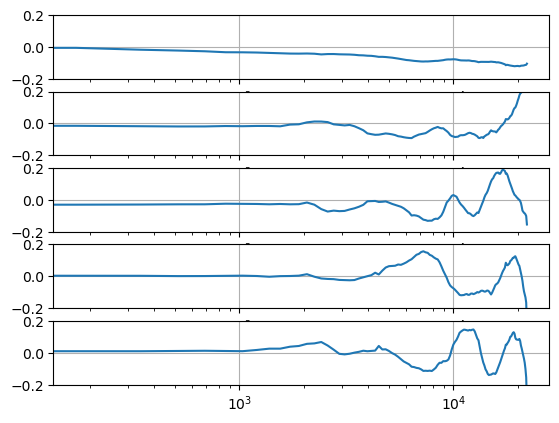

In [15]:
# show principal components
for i in range(0,5):
    plt.subplot(5,1,i+1)
    plt.semilogx(freq, eigen_vecProj[:,i])
    plt.ylim([-0.2,0.2])
    plt.grid(True)

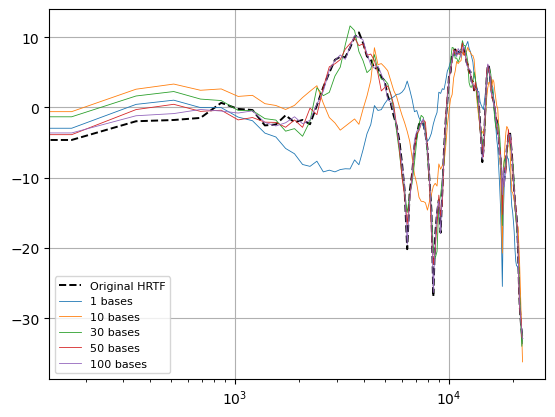

In [16]:
Nbases = [1,5,10,20,30,50,75,100,129]
plt.semilogx(freq, 20*np.log10(np.abs(np.squeeze(HRTFdata_full[0].HRTF_L[11,4,:]))),'--k',linewidth=1.4,label='Original HRTF')
for b in [0,2,4,5,7]:
    plt.semilogx(freq, np.squeeze(PCA_full[0].HRTF2_L[11,4,:,b]),linewidth=0.6,label=str(Nbases[b])+' bases')
plt.legend(fontsize="8")
plt.grid(True, which="both", ls="-")

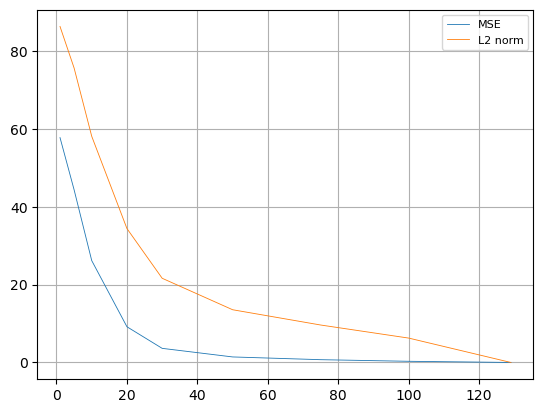

In [19]:
holdMSE=ndarray((len(Nbases)))
holdL2=ndarray((len(Nbases)))   
for b in range(0,len(Nbases)):
    holdMSE[b]=PCA_full[0].MSE_L[11,4,b]
    holdL2[b]=PCA_full[0].L2_L[11,4,b]
plt.plot(Nbases, holdMSE,linewidth=0.6,label='MSE')
plt.plot(Nbases, holdL2,linewidth=0.6,label='L2 norm')
plt.grid(True)
plt.legend(fontsize="8")